In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

# Load and Clean Dataset

In [2]:
# # Load the dataset (replace 'songs.csv' with your actual file)
file_path = Path('Resources/spotify_dataset.csv')
songs_df = pd.read_csv(file_path)
songs_df.shape

(41099, 20)

In [3]:
# Remove duplicate songs
songs_df = songs_df.drop_duplicates(subset=['track', 'artist'], keep='first')

print(f"DataFrame after removing duplicates: {songs_df.shape}")

DataFrame after removing duplicates: (39996, 20)


In [4]:
songs_df = songs_df.reset_index(drop=True)

In [5]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39996 entries, 0 to 39995
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             39996 non-null  object 
 1   artist            39996 non-null  object 
 2   uri               39996 non-null  object 
 3   danceability      39996 non-null  float64
 4   energy            39996 non-null  float64
 5   key               39996 non-null  int64  
 6   loudness          39996 non-null  float64
 7   mode              39996 non-null  int64  
 8   speechiness       39996 non-null  float64
 9   acousticness      39996 non-null  float64
 10  instrumentalness  39996 non-null  float64
 11  liveness          39996 non-null  float64
 12  valence           39996 non-null  float64
 13  tempo             39996 non-null  float64
 14  duration_ms       39996 non-null  int64  
 15  time_signature    39996 non-null  int64  
 16  chorus_hit        39996 non-null  float6

In [6]:
zero_count = (songs_df['instrumentalness'] == 0).sum()
print(zero_count)


11435


In [7]:
# Normalize dataset columns for searching
songs_df['track_lower'] = songs_df['track'].str.strip().str.lower()
songs_df['artist_lower'] = songs_df['artist'].str.strip().str.lower()

In [8]:
songs_df.shape

(39996, 22)

### Get Dummies for Decade Column

In [9]:
# Create dummy variables for the 'decade' column
decade_dummies = pd.get_dummies(songs_df['decade'], prefix='decade')

# Concatenate the dummy variables with the original DataFrame
songs_df = pd.concat([songs_df, decade_dummies], axis=1)

# Drop the original 'decade' column 
songs_df.drop('decade', axis=1, inplace=True)

In [10]:
songs_df.shape

(39996, 27)

In [11]:
songs_df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,sections,popularity,track_lower,artist_lower,decade_00s,decade_10s,decade_60s,decade_70s,decade_80s,decade_90s
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.490,...,9,1,jealous kind of fella,garland green,False,False,True,False,False,False
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.018,...,10,0,initials b.b.,serge gainsbourg,False,False,True,False,False,False
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.846,...,12,0,melody twist,lord melody,False,False,True,False,False,False
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.706,...,8,0,mi bomba sonó,celia cruz,False,False,True,False,False,False
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.857,...,14,0,uravu solla,p. susheela,False,False,True,False,False,False


# Features and Scaling

In [12]:
# Select relevant features for the model

features = [
# 'track',
#  'artist',
#  'uri',
 'danceability',
 'energy',
#  'key',
#  'loudness',
#  'mode',
#  'speechiness',
 'acousticness',
#  'instrumentalness',
 'liveness',
 'valence',
#  'tempo',
#  'duration_ms',
#  'time_signature',
#  'chorus_hit',
#  'sections',
 'popularity',
 'decade_60s',
 'decade_70s',
 'decade_80s',
 'decade_90s',
 'decade_00s',
 'decade_10s'
 ]


X = songs_df[features]



In [13]:
scaler = MinMaxScaler()

# Ensure indices of scaled features match songs_df
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=features,
    index=songs_df.index  # Match the original index
)

In [14]:
X_scaled.head()

,danceability,energy,acousticness,liveness,valence,popularity,decade_60s,decade_70s,decade_80s,decade_90s,decade_00s,decade_10s
0,0.422065,0.619905,0.491968,0.065822,0.848394,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.504049,0.504876,0.018072,0.165314,0.800201,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.664980,0.648912,0.849398,0.107505,0.911647,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.597166,0.544886,0.708835,0.048682,0.970884,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.521255,0.764941,0.860442,0.202840,0.909639,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Apply Weights

In [35]:
# Feature weighting
weights = {
    'danceability': 1.2,
    'energy': 1.7,
    'acousticness': 1.0,
    'liveness': 1.5,
    'valence': 1.6,
    'popularity': 0.4,
    'decade_60s': 0.4,
    'decade_70s': 0.4,
    'decade_80s': 0.4,
    'decade_90s': 0.4,
    'decade_00s': 0.4,
    'decade_10s': 0.4
}

In [36]:
# Apply the weights to the scaled features
weighted_features = X_scaled * pd.Series(weights)

In [37]:
weighted_features.tail()

,danceability,energy,acousticness,liveness,valence,popularity,decade_60s,decade_70s,decade_80s,decade_90s,decade_00s,decade_10s
39991,0.208907,0.608326,0.889558,0.457911,0.057992,0.0,0.0,0.0,0.0,0.0,0.0,0.4
39992,1.105263,0.621929,0.100000,0.377282,1.188755,0.4,0.0,0.0,0.0,0.0,0.0,0.4
39993,0.873279,1.366716,0.013253,0.191684,0.971888,0.4,0.0,0.0,0.0,0.0,0.0,0.4
39994,0.728745,0.300549,0.992972,0.206897,0.899598,0.0,0.0,0.0,0.0,0.0,0.0,0.4
39995,0.146964,0.208726,0.967871,0.136917,0.047711,0.0,0.0,0.0,0.0,0.0,0.0,0.4


# NN Model

In [38]:
# Train a k-Nearest Neighbors model
model = NearestNeighbors(n_neighbors=15, algorithm='ball_tree')
model.fit(weighted_features)

NearestNeighbors(algorithm='ball_tree', n_neighbors=15)

# Visual Code

In [29]:
def visualize_features(original_features, recommendation_features, feature_names, song_title, artist_name):

    plt.style.use('default')

    # Identify indices of the decade features
    decade_indices = [i for i, name in enumerate(feature_names) if 'decade_' in name]

    # Create a mask to filter out the decade features
    mask = np.ones(len(feature_names), dtype=bool)
    mask[decade_indices] = False  # Set decade features to False

    # Filter original and recommendation features
    filtered_original_features = original_features[0, mask]
    filtered_recommendation_features = np.array(recommendation_features)[:, mask].mean(axis=0)
    filtered_feature_names = [feature_names[i] for i in range(len(feature_names)) if mask[i]]

    # Prepare the x-axis
    x = np.arange(len(filtered_feature_names))

    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, filtered_original_features, width=0.4, label=f"{song_title} by {artist_name}", color='#fa340c') 
    plt.bar(x + 0.2, filtered_recommendation_features, width=0.4, label="Recommended Songs (Average)", color='#419edf') 
    
    plt.xticks(x, filtered_feature_names, ha='right')
    plt.title(f"{song_title} by {artist_name} vs Recommendations", fontsize=14, fontweight='bold')
    plt.ylabel("Scaled Feature Values", fontsize=12)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

In [30]:
from adjustText import adjust_text  # pip install adjustText

def visualize_tsne(original_features, recommendation_features, recommendations, song_title, artist_name):
    
    all_features = np.vstack([original_features, recommendation_features])  # Stack features
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(len(all_features) - 1, 5))  # Adjust perplexity
    tsne_results = tsne.fit_transform(all_features)

    plt.figure(figsize=(10, 6))
    
    # Plot the input song
    plt.scatter(tsne_results[0, 0], tsne_results[0, 1], color='#fa340c', s=120)
    texts = [plt.text(tsne_results[0, 0] + 0.5, tsne_results[0, 1] + 0.5, f"{song_title}", fontsize=10)]

    # Plot the recommended songs and display their full track names
    for i, (track, artist) in enumerate(recommendations):
        plt.scatter(tsne_results[i + 1, 0], tsne_results[i + 1, 1], color='#419edf', s=60)
        texts.append(plt.text(tsne_results[i + 1, 0] + 0.5, tsne_results[i + 1, 1] + 0.5, f"#{i+1}: {track}", fontsize=9))

    plt.title(f"{song_title} by '{artist_name}' and Recommendations", fontsize=12, fontweight='bold')
    plt.tight_layout()
    
    # Adjust text to minimize overlap
    adjust_text(texts)

    plt.show()

In [31]:
def recommend_songs_with_visuals(song_title, artist_name, num_recommendations=5):
    # Preprocess input
    song_title = song_title.strip().lower()
    artist_name = artist_name.strip().lower()

    # Filter the dataset for the input song and artist with case-insensitive partial matching
    song_row = songs_df[
        (songs_df['track_lower'].str.contains(song_title)) & 
        (songs_df['artist_lower'].str.contains(artist_name))
    ]
    
    if song_row.empty:
        print(f"Error: Song '{song_title}' by '{artist_name}' not found in the dataset.")
        return

    # Get the index and weighted features of the input song
    song_index = song_row.index[0]
    song_features = weighted_features.loc[song_index].values.reshape(1, -1) 

    # Convert to DataFrame with correct feature names
    song_features_df = pd.DataFrame(song_features, columns=weighted_features.columns)

    # Find nearest neighbors
    distances, indices = model.kneighbors(song_features_df)
    
    # Map indices back to the original DataFrame
    recommendations = []
    recommendation_features = []  # Store features of recommended songs

    for i in indices.flatten():
        original_index = songs_df.index[i]  # Map to original index
        if (songs_df.loc[original_index, 'track_lower'] != song_row.iloc[0]['track_lower'] and 
            songs_df.loc[original_index, 'artist_lower'] != song_row.iloc[0]['artist_lower']):
            recommendations.append((songs_df.loc[original_index, 'track'], songs_df.loc[original_index, 'artist']))
            recommendation_features.append(weighted_features.loc[original_index].values)  # Add weighted features
        if len(recommendations) >= num_recommendations:
            break

    # Print recommendations with the correct original case for song and artist names
    original_song = song_row.iloc[0]['track']
    original_artist = song_row.iloc[0]['artist']
    
    print(f"Recommendations for '{original_song}' by {original_artist}:")
    for track, artist in recommendations:
        print(f"- {track} by {artist}")

    # Visualize features comparison
    visualize_features(
        song_features, recommendation_features, weighted_features.columns, original_song, original_artist
    )

    # Visualize t-SNE of input song and recommendations
    visualize_tsne(
        song_features, recommendation_features, recommendations, original_song, original_artist
    )

Recommendations for 'Dark Horse' by Katy Perry Featuring Juicy J:
- Check by Young Thug
- Love Faces by Trey Songz
- Cool For The Summer by Demi Lovato
- Pride. by Kendrick Lamar
- Boyfriend by Justin Bieber
- Dope by Tyga Featuring Rick Ross
- Falling Down by Lil Peep & XXXTENTACION
- Ordinary Love by U2


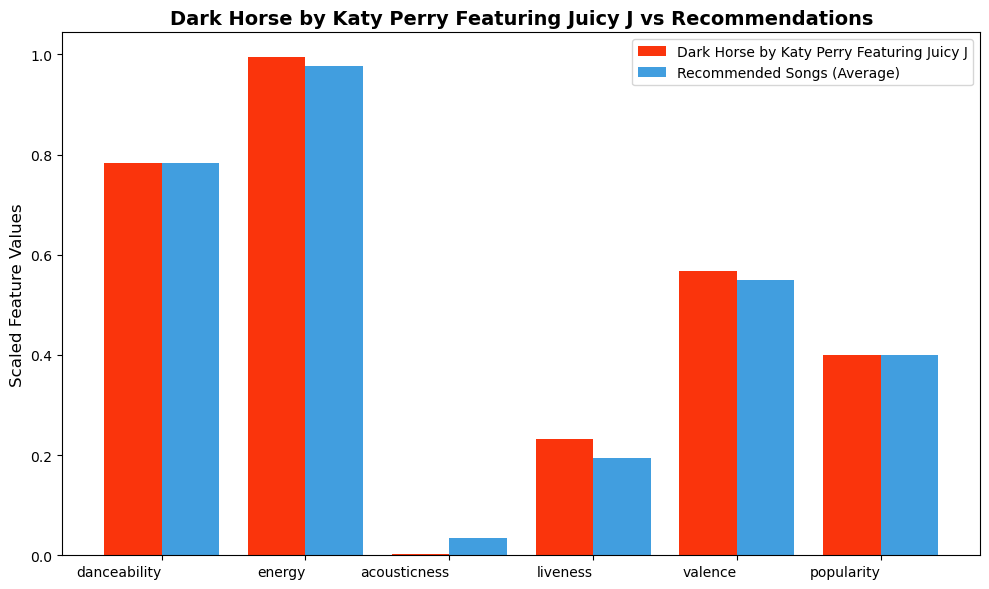

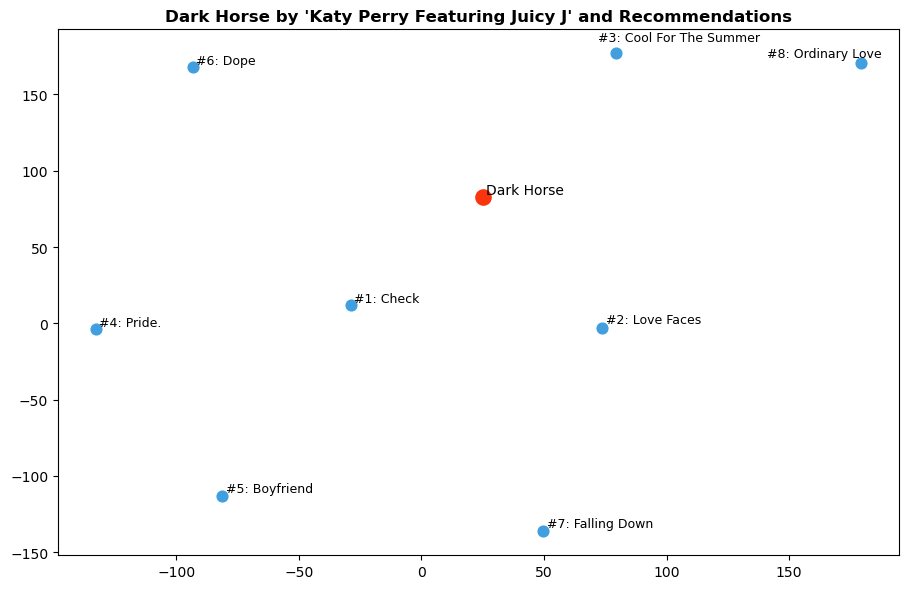

In [39]:
recommend_songs_with_visuals("dark", "katy", 8)

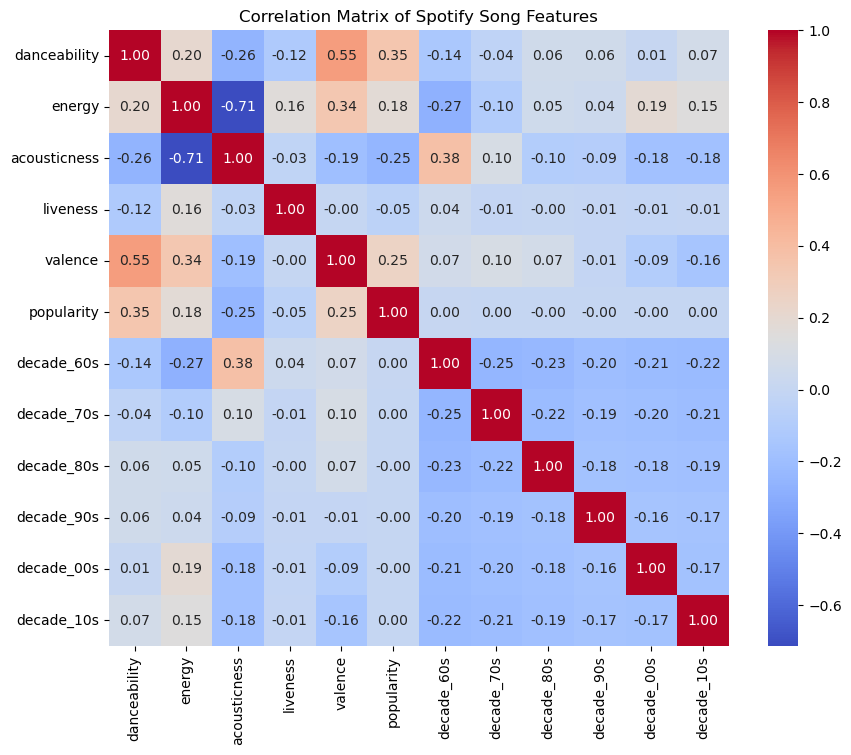

In [40]:
# Compute the correlation matrix for the original features (before scaling)
correlation_matrix = X.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Spotify Song Features")
plt.show()